In [1]:
!pip install networkx

# 1. Load dataset


In [3]:
from __future__ import division
from __future__ import print_function

import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import networkx as nx

'''use tensforflow v1 in this example'''
import tensorflow.compat.v1 as tf
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

## Define some useful parameters for GCN model training

In [4]:
seed = 42
np.random.seed(seed)
tf.disable_eager_execution()

## Define some useful utility functions

In [40]:
# Download data from github
# ! wget https://github.com/OSU-BMBL/BMI8050-2020/raw/master/5_gcn_example/data/yeast.edgelist
# ! wget https://github.com/OSU-BMBL/BMI8050-2020/blob/master/5_gcn_example/data/yeast_sample.edgelist?raw=true


def load_data():
  g = nx.read_edgelist('yeast.edgelist.txt')
  adj = nx.adjacency_matrix(g)

  return adj

def weight_variable_glorot(input_dim, output_dim, name=""):
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.random_uniform(
        [input_dim, output_dim], minval=-init_range,
        maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def dropout_sparse(x, keep_prob, num_nonzero_elems):
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1. / keep_prob)


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape


def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    # Symmetrically normalized adjacency matrix:
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(adj_normalized, adj, features, placeholders):
    feed_dict = dict()
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['adj']: adj_normalized})
    feed_dict.update({placeholders['adj_orig']: adj})
    return feed_dict


def mask_test_edges(adj):
    # Function to build test set with 2% positive links
    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    edges_all = sparse_to_tuple(adj)[0]
    num_test = int(np.floor(edges.shape[0] / 50.))
    num_val = int(np.floor(edges.shape[0] / 50.))

    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

    def ismember(a, b):
        rows_close = np.all((a - b[:, None]) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        n_rnd = len(test_edges) - len(test_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]                                        
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], edges_all):
                continue
            if test_edges_false:
                if ismember([idx_j, idx_i], np.array(test_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(test_edges_false)):
                    continue
            test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        n_rnd = len(val_edges) - len(val_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]                                        
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], train_edges):
                continue
            if ismember([idx_j, idx_i], train_edges):
                continue
            if ismember([idx_i, idx_j], val_edges):
                continue
            if ismember([idx_j, idx_i], val_edges):
                continue
            if val_edges_false:
                if ismember([idx_j, idx_i], np.array(val_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(val_edges_false)):
                    continue
            val_edges_false.append([idx_i, idx_j])

    # Re-build adj matrix
    data = np.ones(train_edges.shape[0])
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false


def get_roc_score(edges_pos, edges_neg):
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.embeddings, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [41]:
#load example data
adj = load_data()
num_nodes = adj.shape[0]
num_edges = adj.sum()
# Featureless
features = sparse_to_tuple(sp.identity(num_nodes))
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train
adj_norm = preprocess_graph(adj)

# 2. Background
In this example, we demonstrate the utility of deep learning methods for an important prediction problem on biological graphs. In particular, we consider the problem of predicting [protein-protein interactions (PPIs)](https://en.wikipedia.org/wiki/Protein–protein_interaction).

## 2.1 Why use computational methods to predict PPI?
We represent the totality of PPIs that happen in a cell, an organism or a specific biological context with a protein-protein interaction network. These networks are mathematical representations of all physical contacts between proteins in the cell. Protein-protein interactions (PPIs) are essential to almost every process in a cell. Understanding PPIs is crucial for understanding cell physiology in normal and disease states.

The development of large-scale PPI screening techniques, especially [high-throughput affinity purification combined with mass-spectrometry](https://doi.org/10.1016/j.tibtech.2016.02.014) and the [yeast two-hybrid assay](https://en.wikipedia.org/wiki/Two-hybrid_screening), has caused an explosion in the amount of PPI data and the construction of ever more complex and complete interaction networks. However, current knowledge of protein-protein interaction networks is both [incomplete and noisy](https://doi.org/10.1016/j.cell.2014.10.050), as PPI screening techniques are limited in how many true interactions they can detect. Furthermore, PPI screening techniques often have high false positive and negative rates. These limitations present a great opportunity for computational methods to predict protein-protein interactions.

## 2.2 STRING (Search Tool for the Retrieval of Interacting Genes/Proteins)
The STRING database collects score and integrate all publicly available sources of protein–protein interaction information, and to complement these with computational predictions. It achieves a comprehensive and objective global network, including direct (physical) as well as indirect (functional) interactions. The latest version of STRING (11.0) more than doubles the number of organisms it covers, to 5,090. It covers 24,584,628 proteins and 3,123,056,667 total interactions. The STRING resource is available online at https://string-db.org/.

<img src='https://camo.githubusercontent.com/c4c43bcd0fc2d008c90f3e342bbb93234313116ef9ffc33a6fd670ace0643a01/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4372797374616c2d4a4a2f6d61697a652f6d61737465722f646174612f313630333035343932343536352e6a7067'>

In this demo, we take the yeast protein-protein interaction network (download the preprocessed network) and use the network to build a model for predicting new protein-protein interactions. We formulate this prediction task as **a link prediction problem on unweighted and undirected networks** and use a graph convolutional neural network to solve the task.

In [38]:
f = open("yeast.edgelist.txt", "r")
for i in range(10):
    print(f.readline())

YLR418C	YOL145C

YOL145C	YLR418C

YLR418C	YOR123C

YOR123C	YLR418C

YLR418C	YBR279W

YBR279W	YLR418C

YLR418C	YML069W

YML069W	YLR418C

YLR418C	YGL244W

YGL244W	YLR418C



In [42]:
# Function to build test set with 2% positive links
# Remove diagonal elements
print("``````````````````````````````````")
print("Total nodes: ", num_nodes)
print("Total edges: ", num_edges)
print("Adjacency matrix: ", adj_orig.shape)
print("``````````````````````````````````")
print("Training edges: ", train_edges.shape)
print("``````````````````````````````````")
print("Positive validation edges: ", val_edges.shape)
print("Negative validation edges: ", np.array(val_edges_false).shape)
print("``````````````````````````````````")
print("Positive testing edges: ", test_edges.shape)
print("Negative testing edges: ", np.array(test_edges_false).shape)
print("``````````````````````````````````")

``````````````````````````````````
Total nodes:  6526
Total edges:  1062675
Adjacency matrix:  (6526, 6526)
``````````````````````````````````
Training edges:  (509277, 2)
``````````````````````````````````
Positive validation edges:  (10609, 2)
Negative validation edges:  (10609, 2)
``````````````````````````````````
Positive testing edges:  (10609, 2)
Negative testing edges:  (10609, 2)
``````````````````````````````````


We will use the network to build a model for predicting new protein-protein interactions. We formulate this prediction task as **a link prediction problem on unweighted and undirected networks** and use a graph convolutional neural network to solve the task.

Note that link prediction is a standard prediction task in network biology, and thus this example can be easily extended and adapted to many other biomedical applications.

<img src='https://camo.githubusercontent.com/f2c91ec845aed503bfbb7c6d9b1aa23253d30fe4ac887c5b4842697273e99b2a/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4372797374616c2d4a4a2f6d61697a652f6d61737465722f646174612f313630333035373037373438372e6a7067'>

## 2.4 The example model
<img src='https://camo.githubusercontent.com/17f3047ffdd90587c662a7740968d62956b47984b1a5f4192f9da277b9f99329/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f4372797374616c2d4a4a2f6d61697a652f6d61737465722f646174612f46383042313037444642333735453931434441413435374541343341383445432e706e67'>

In this demo, the GCN model contains a total of 4 layers, including the input layer, the 1st hidden layer, the 2nd hidden layer, and the output layer

1. Input layer: Protein–protein interaction data, and the protein interaction data is used to construct a protein interaction network. Since we are using an undirected graph here, the data contains a total of 2 columns, the 1st column is protein 1, the 2nd column is protein 2

2. Hidden layer 1: The node's one-step interaction neighbors transfer information to the selected node. Find the one-step neighbors of the red node, that is, the blue nodes.

3. Hidden layer 2: The output of hidden layer one is the input of hidden layer 2. The current node's one-step interaction neighbors transfer information to the current node. We are looking for the blue nodes one-step interaction neighbors, that is, yellow nodes.

4. Output layer: The output layer is a network. Compare the edges in the output network with the edges in the input network, and evaluate the performance of the model by counting which edges actually exist in the input network

## 2.5 Graph Convolutional Neural Network (GCN)

In what follows, we give a complete Tensorflow implementation of a two-layer graph convolutional neural network (GCN) for link prediction. We closely follow the GCN formulation as presented in [Kipf et al., ICLR 2017](https://arxiv.org/pdf/1609.02907.pdf).

In [29]:
class GraphConvolution():
    """Basic graph convolution layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, adj, name, dropout, activate=tf.nn.relu):
        self.name = name
        self.vars = {}
        self.issparse = False
        with tf.variable_scope(self.name + '_vars'):
            '''Create a weight variable with Glorot & Bengio'''
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name='weights')
        self.dropout = dropout
        self.adj = adj
        self.activate = activate

    def __call__(self, inputs):
        with tf.name_scope(self.name):        
            x = inputs
            '''In tensorflow v1, the second argument represents the percentage to keep original values'''
            x = tf.nn.dropout(x, 1-self.dropout)
            x = tf.matmul(x, self.vars['weights'])
            x = tf.sparse_tensor_dense_matmul(self.adj, x)
            outputs = self.activate(x)
        return outputs


class GraphConvolutionSparse():
    """Graph convolution layer for sparse inputs."""
    def __init__(self, input_dim, output_dim, adj, features_nonzero, name, dropout, activate=tf.nn.relu):
        self.name = name
        self.vars = {}
        self.issparse = False
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name='weights')
        self.dropout = dropout
        self.adj = adj
        self.activate = activate
        self.issparse = True
        self.features_nonzero = features_nonzero

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            x = inputs
            x = dropout_sparse(x, 1-self.dropout, self.features_nonzero)
            x = tf.sparse_tensor_dense_matmul(x, self.vars['weights'])
            x = tf.sparse_tensor_dense_matmul(self.adj, x)
            outputs = self.activate(x)
        return outputs
    
    
class InnerProductDecoder():
    """Decoder model layer for link prediction."""
    def __init__(self, input_dim, name, dropout, activate=tf.nn.sigmoid):
        self.name = name
        self.issparse = False
        self.dropout = dropout
        self.activate = activate

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            inputs = tf.nn.dropout(inputs, 1-self.dropout)
            x = tf.transpose(inputs)
            x = tf.matmul(inputs, x)
            x = tf.reshape(x, [-1])
            outputs = self.activate(x)
        return outputs

# 3. Specify the architecture of our GCN model
Next, we choose a simple GCN, which is commonly used in deep learning for relationships betwwen proteins. For our yeast PPI network, the GCN model contains a total of four layers, including the input layer, the first hidden layer, the second hidden layer, and the output layer.

In [30]:
features_nonzero

6526

In [31]:
class GCNModel():
    def __init__(self, placeholders, num_features, features_nonzero, name):
        self.name = name
        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        with tf.variable_scope(self.name):
            self.build()
        
    def build(self):
        self.hidden1 = GraphConvolutionSparse(
            name='gcn_sparse_layer',
            input_dim=self.input_dim,
            output_dim=HIDDEN1,
            adj=self.adj,
            features_nonzero=self.features_nonzero,
            activate=tf.nn.relu,
            dropout=self.dropout)(self.inputs)
        
        self.embeddings = GraphConvolution(
            name='gcn_dense_layer',
            input_dim=HIDDEN1,
            output_dim=HIDDEN2,
            adj=self.adj,
            activate=lambda x: x,
            dropout=self.dropout)(self.hidden1)

        self.reconstructions = InnerProductDecoder(
            name='gcn_decoder',
            dropout = self.dropout,
            input_dim=HIDDEN2, 
            activate=lambda x: x)(self.embeddings)

In [32]:
# Specify the GCN optimizer
class Optimizer():
  def __init__(self, preds, labels, num_nodes, num_edges):
    pos_weight = float(num_nodes**2 - num_edges) / num_edges
    norm = num_nodes ** 2 / float((num_nodes ** 2 - num_edges) * 2)

    preds_sub = preds
    labels_sub = labels

    # loss function
    self.cost = norm * tf.reduce_mean(
        tf.nn.weighted_cross_entropy_with_logits(
            logits = preds_sub, targets = labels_sub, pos_weight = pos_weight))
    self.optimizer = tf.train.AdamOptimizer(learning_rate = LEARNING_RATE) # Adam optimizer
    
    self.opt_op = self.optimizer.minimize(self.cost)
    self.grads_vars = self.optimizer.compute_gradients(self.cost)

# 4. Train the GCN Model & Evaluate on test set

Given a training set of protein-protein interactions in yeast S. cerevisiae, our goal is to take these interactions and train a GCN model that can predict new protein-protein interactions. That is, we would like to predict new edges in the yeast protein interaction network.

In [33]:
# Define hyperparameters
'''Initial learning rate.'''

LEARNING_RATE = 0.01
'''Number of epochs to train.'''
EPOCHS= 50
'''Number of units in hidden layer 1.'''
HIDDEN1 = 32
'''Number of units in hidden layer 2.'''
HIDDEN2 = 16
'''Dropout rate.'''
DROPOUT = 0.1

In [34]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0.0, shape=())
}


# Pay attention to the factors that the placeholders have
model = GCNModel(placeholders, num_features, features_nonzero, name='yeast_gcn')

# Create optimizer
with tf.name_scope('optimizer'):
    opt = Optimizer(
        preds=model.reconstructions,
        labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'], validate_indices=False), [-1]),
        num_nodes=num_nodes,
        num_edges=num_edges)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
targets is deprecated, use labels instead


In [43]:
# initialize session
sess = tf.Session()

sess.run(tf.global_variables_initializer())

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

losses, roc, ap = [], [], []

# Train model
for epoch in range(EPOCHS):
  t = time.time()
  # Construct feed dictionary
  feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
  feed_dict.update({placeholders['dropout']: DROPOUT})

  # One update of parameter matrices
  _, avg_cost = sess.run([opt.opt_op, opt.cost], feed_dict = feed_dict)

  roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
  roc.append(roc_curr)
  ap.append(ap_curr)
  losses.append(avg_cost)

  print("Epoch:", '%04d' % (epoch + 1), 
          "train_loss=", "{:.5f}".format(avg_cost),
          "validation_roc=", "{:.5f}".format(roc_curr),
          "validation_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))
  
print('Optimization Finished!')
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)

print('Test ROC score: {:.5f}'.format(roc_score))
print('Test AP score: {:.5f}'.format(ap_score))

Epoch: 0001 train_loss= 0.68120 validation_roc= 0.82880 validation_ap= 0.79661 time= 2.24911
Epoch: 0002 train_loss= 0.68119 validation_roc= 0.87319 validation_ap= 0.86570 time= 2.10830
Epoch: 0003 train_loss= 0.68112 validation_roc= 0.87934 validation_ap= 0.87036 time= 2.08038
Epoch: 0004 train_loss= 0.68071 validation_roc= 0.87980 validation_ap= 0.87063 time= 2.07405
Epoch: 0005 train_loss= 0.67932 validation_roc= 0.87984 validation_ap= 0.87065 time= 2.08619
Epoch: 0006 train_loss= 0.67652 validation_roc= 0.87984 validation_ap= 0.87064 time= 2.08832
Epoch: 0007 train_loss= 0.67144 validation_roc= 0.87984 validation_ap= 0.87062 time= 2.09071
Epoch: 0008 train_loss= 0.66291 validation_roc= 0.87983 validation_ap= 0.87061 time= 2.06512
Epoch: 0009 train_loss= 0.65214 validation_roc= 0.87983 validation_ap= 0.87060 time= 2.06771
Epoch: 0010 train_loss= 0.63810 validation_roc= 0.87982 validation_ap= 0.87058 time= 2.08063
Epoch: 0011 train_loss= 0.62392 validation_roc= 0.87982 validation_ap=

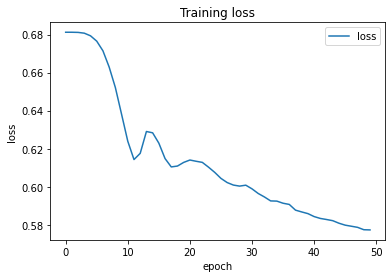

In [44]:
plt.figure()
plt.plot(losses)
plt.title('Training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'])
plt.show()

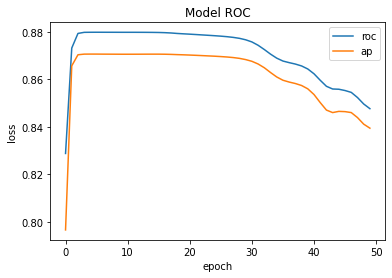

In [45]:
plt.figure()
plt.plot(roc)
plt.plot(ap)
plt.title('Model ROC')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['roc','ap'])
plt.show()

In [48]:
adj

<6526x6526 sparse matrix of type '<class 'numpy.float64'>'
	with 1018554 stored elements in Compressed Sparse Row format>